### Figure 1
- schematic
- spectrogram for NSD and SD
- percentage sleep fraction during first 5h of POST for both SD and NSD sessions


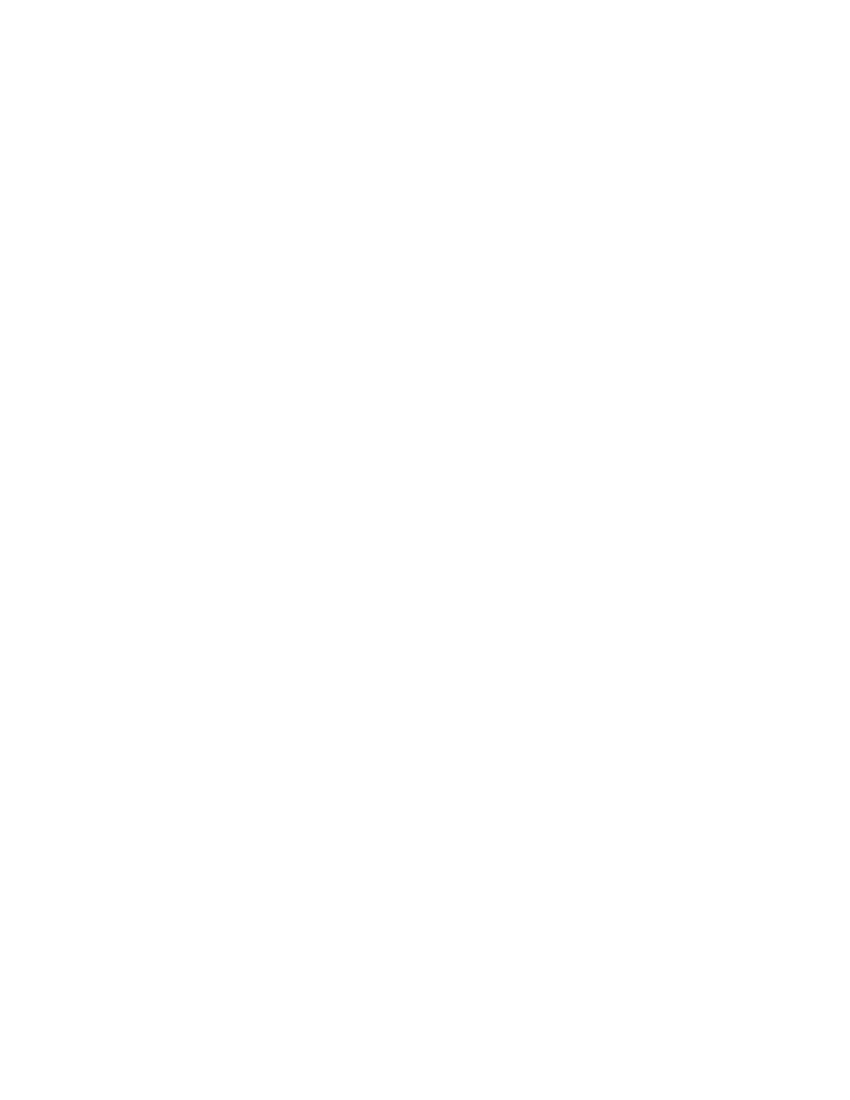

In [349]:
import matplotlib.pyplot as plt
import numpy as np
import subjects
from plotters import violinplot
import pandas as pd
import seaborn as sns
from neuropy.plotting import Fig
from scipy import stats
from subjects import (
    light_cycle_span,
    sns_boxplot_kw,
    stat_kw,
    sns_violin_kw,
    epoch_span,
)

grpdata = subjects.GroupData()
group = ["NSD", "SD"]

# SWA
swa, swa_time, swa_states = grpdata.swa_examples.values()
# brainstates
states = grpdata.brainstates_proportion

# frate
frate = grpdata.frate_ratio_nsd_vs_sd
frate_chunks = grpdata.frate_post_chunks
frate_change = grpdata.frate_change_pre_to_post
colors_frate_change = subjects.colors_sd()

frate_quantiles = grpdata.frate_pre_to_maze_quantiles_in_POST
# frate_quantiles_shuffled= grpdata.frate_pre_to_maze_quantiles_in_POST_shuffled

plt.close()
fig = Fig(grid=(7, 8), fontsize=7, constrained_layout=False, hspace=0.3)

filename = subjects.figpath_sd / "figure1"

### SWA

In [350]:
from neuropy.plotting import plot_epochs

subfig = fig.fig.add_subfigure(fig.gs[:2, :2])
axs = subfig.subplots(4, 1,sharex=True, gridspec_kw=dict(height_ratios=[1, 4,1,4]))
# axs[0].plot([1,2,3],[1,2,3])
# axs = axs.reshape(2, 2).T
for i in range(2):
    time = swa_time[i]

    ax = axs[2*i]
    plot_epochs(
        swa_states[i],
        ax=ax,
        labels_order=["nrem", "rem", "quiet", "active"],
        colors=subjects.colors_sleep_old,
    )
    # axs[0,i].set_xlim(time[0],time[-1])
    ax.set_xlim(0,8*3600)
    ax.axis("off")

    ax = axs[2*i+1]
    ax.plot(time, swa[i],color=subjects.colors_sd(0.9)[i],lw=1)
    # axs[1, i].step(time, swa[i],color=subjects.colors_sd(1.4)[i])
    # axs[1, i].fill_between(time, swa[i],color=subjects.colors_sd(1.4)[i],alpha=0.5)
    # axs[1, i].fill_between(time, swa[i],ec=subjects.colors_sd(1.5)[i],color=subjects.colors_sd(1.5)[i],alpha=0.6)
    ax.set_xlim(0,8*3600)
    ax.set_ylim(0,0.35)
    # if i ==0:
    #     axs[1,i].set_xticks([])
    # if i==1:
    xticks = np.arange(0,8,2)*3600+ time[0] 
    ax.set_xticks(xticks, np.arange(0,8,2))
    ax.set_xlabel('Zt time (h)')
    ax.set_ylabel('SWA (m$V^2$/Hz)')


### firing rate ratio across session

In [351]:
neuron_colors = ["#f32f74ff", "#5644a4ff"]
# neuron_colors = ["#C460DC", "#78DC60"]
# neuron_colors = [subjects.colors_sd(1), subjects.colors_sd(1)]
subfig = fig.fig.add_subfigure(fig.gs[:2, 2:5])
axs = subfig.subplots(2, 1,sharex=True,sharey=True)
for i1, grp in enumerate(group):

    ax_inter = axs[i1]
    ax_inter.set_xlabel("ZT time (h)")
    ax_inter.set_ylabel("IN firing rate (Hz)")
    ax_inter.set_xlim([-3.5, 8])
    epoch_span(ax_inter,grp)

    ax_pyr = ax_inter.twinx()
    ax_pyr.set_ylim([0.4, 1.4])
    ax_pyr.set_yticks([0.5, 0.8,1.1])
    ax_pyr.set_ylabel("PN firing rate (Hz)")
    fig.toggle_spines(ax_pyr,['right'],True)

    for i, (neuron_type, ax) in enumerate(zip(["pyr", "inter"], [ax_pyr, ax_inter])):
        # ls = "--" if neuron_type == "inter" else "-"
        marker = "o" if neuron_type == "inter" else "o"

        indx = (frate["grp"] == grp) & (frate["neuron_type"] == neuron_type)
        df = frate[indx].groupby("zt")

        # color = subjects.colors_sd(0.7)[i1]
        color = neuron_colors[i]

        y = df.mean().frate
        x = y.index
        err = df.sem(ddof=0).frate.values
        ax.fill_between(
            x, y - err, y + err, color=color, alpha=0.3, ec=None, zorder=1
        )
        ax.plot(x, y, color=color, lw=1, zorder=2, markersize=2)

        # baseline=====
        # ax.axhline(100, ls="--", color="#4d7ff5")

        light_cycle_span(ax, -3.5, 8)
        # epoch_span(ax)


        # ax_frate.set_ylim([-1.2, 1.7])


### Firing rate in 2.5 hour windows

In [352]:
from matplotlib import ticker
from statannotations.Annotator import Annotator

# ax1 = fig.subplot(fig.gs[3, :2])
# ax2 = fig.subplot(fig.gs[3, 2:4], sharey=ax1)
# axs = [ax1, ax2]
# subfig = fig.add_subfigure(fig.gs[3,2:5])
gs_ = fig.subplot2grid(fig.gs[3,:5],grid=(1,6))
ax1 = fig.subplot(gs_[:2])
ax2 = fig.subplot(gs_[2:4],sharey=ax1)
axs=[ax1,ax2]
frate_chunks["frate_log"] = np.log10(frate_chunks["frate"])
for i, n in enumerate(["pyr", "inter"]):
    df = frate_chunks[frate_chunks["neuron_type"] == n]

    # ax = fig.subplot(fig.gs[0, i + 4])
    ax = axs[i]
    plot_kw = dict(data=df, x="zt", y="frate_log", hue="grp", hue_order=group, ax=ax)
    ax=violinplot(**plot_kw)
    # sns.stripplot(**plot_kw,dodge=True,s=3)
    # ax.set_yscale('log')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend("", frameon=False)
    if i==0:
        ax.set_ylabel("Firing rate (Hz)")
    ax.tick_params("x", labelrotation=30)
    ax.set_ylim(-3, 4)

    if i==0:
        ax.set_yticks([-2, 0, 2])
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))

    # stats
    orders = df.zt.unique()
    # pairs = [((_, "NSD"), (_, "SD")) for _ in orders]
    # annotator = Annotator(pairs=pairs, order=orders, **plot_kw)
    # annotator.configure(test="t-test_welch", **stat_kw)
    # annotator.apply_and_annotate()
    # annotator.reset_configuration()

    # paired test in SD
    # pairs = [((orders[i], g), (orders[i + 1], g)) for g in group for i in range(3)]
    pairs = [((orders[0], g), (orders[i], g)) for g in group for i in range(1,4)]

    # pairs = [
    #     (("0-2.5", "NSD"), ("2.5-5", "NSD")),
    #     (("0-2.5", "SD"), ("2.5-5", "SD")),
    # ]

    annotator = Annotator(pairs=pairs, order=orders, **plot_kw)
    annotator.configure(test="Wilcoxon", **stat_kw)
    annotator.apply_and_annotate()
    annotator.reset_configuration()


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PRE_NSD vs. 0-2.5_NSD: Wilcoxon test (paired samples), P_val:2.012e-03 Stat=3.707e+04
PRE_SD vs. 0-2.5_SD: Wilcoxon test (paired samples), P_val:3.517e-04 Stat=1.859e+04
PRE_NSD vs. 2.5-5_NSD: Wilcoxon test (paired samples), P_val:2.225e-01 Stat=4.177e+04
PRE_SD vs. 2.5-5_SD: Wilcoxon test (paired samples), P_val:1.202e-05 Stat=1.731e+04
PRE_NSD vs. 5-7.5_NSD: Wilcoxon test (paired samples), P_val:8.192e-01 Stat=4.426e+04
PRE_SD vs. 5-7.5_SD: Wilcoxon test (paired samples), P_val:8.788e-01 Stat=2.402e+04
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PRE_NSD vs. 0-2.5_NSD: Wilcoxon test (paired samples), P_val:1.721e-01 Stat=3.780e+02
PRE_SD vs. 0-2.5_SD: Wilcoxon test (paired

/home/bapung/miniconda3/envs/data_analysis/lib/python3.10/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bapung/miniconda3/envs/data_analysis/lib/python3.10/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bapung/miniconda3/envs/data_analysis/lib/python3.10/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bapung/miniconda3/envs/data_analysis/lib/python3.10/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are 

### coefficient of variation

### E/I ratio

In [353]:
# ax = fig.subplot(fig.gs[3,:2])
subfig = fig.fig.add_subfigure(fig.gs[4, 3])
axs = subfig.subplots(1, 1, sharey=True)
ax = axs

frate_change = frate_change[frate_change.zt!='PRE']
t = frate_change["zt"].unique()
for g, grp in enumerate(group):
    df = (
        frate_change[frate_change["grp"] == grp]
        .groupby(["neuron_type", "zt"], sort=False)
        .mean()
    )
    ei_ratio = df.loc["pyr"].frate_change / df.loc["inter"].frate_change

    ax.plot(ei_ratio, color=subjects.colors_sd(0.9)[g],marker='o',markersize=4)

ax.set_ylim([0.5,2.5])
ax.set_xlim([-0.5,2.5])
ax.tick_params("x", labelrotation=30)

# light_cycle_span(ax, -3.5, 8)
# ax.set_xticks(np.arange(-2,10,2))
ax.axhline(1, ls="--", color="#4d7ff5")
ax.set_xlabel("Zt time (h)")
ax.set_ylabel("E/I ratio")


Text(0, 0.5, 'E/I ratio')

### saving

In [354]:
fig.savefig(filename)

meta NOT subset; don't know how to subset; dropped
